# Chapter 9 - Data Science

## 0 - Setting up the notebook

In [1]:
import json
import calendar
import random
from datetime import date, timedelta
import faker
import numpy as np
from pandas import DataFrame
from delorean import parse
import pandas as pd
from matplotlib import pyplot as plt

# make the graphs nicer
#pd.set_option('display.mpl_style', 'default') #depreciate
plt.style.use('ggplot')

## 1 - Preparing the Data

In [2]:
# create the faker to populate the data
fake = faker.Faker()

In [3]:
usernames = set()
usernames_no = 1000

# populate the set with 1000 unique usernames
while len(usernames) < usernames_no:
    usernames.add(fake.user_name())

In [4]:
def get_random_name_and_gender():
    skew = .6  # 60% of users will be female
    male = random.random() > skew
    if male:
        return fake.name_male(), 'M'
    else:
        return fake.name_female(), 'F'

# for each username, create a complete user profile
# simulate user data coming from an API. It is a list
# of JSON strings (users).
def get_users(usernames):
    users = []
    for username in usernames:
        name, gender = get_random_name_and_gender()
        user = {
            'username': username,
            'name': name,
            'gender': gender,
            'email': fake.email(),
            'age': fake.random_int(min=18, max=90),
            'address': fake.address(),
        }
        users.append(json.dumps(user))
    return users

users = get_users(usernames)
users[:3]

['{"username": "davidking", "name": "Nicole Hill", "gender": "F", "email": "charles92@gmail.com", "age": 45, "address": "35399 Marissa Shoals\\nSouth Brooke, MN 16520-1740"}',
 '{"username": "sherry20", "name": "Melissa Young", "gender": "F", "email": "carrie19@rodriguez.org", "age": 65, "address": "168 Kara Avenue Apt. 812\\nWest Jeremyville, CO 53956"}',
 '{"username": "haynesshannon", "name": "Randy Douglas", "gender": "M", "email": "ubrown@jensen.com", "age": 48, "address": "2307 Lisa Loaf Apt. 585\\nDanielborough, OH 79534"}']

In [5]:
# campaign name format:
# InternalType_StartDate_EndDate_TargetAge_TargetGender_Currency
def get_type():
    # just some gibberish internal codes
    types = ['AKX', 'BYU', 'GRZ', 'KTR']
    return random.choice(types)

def get_start_end_dates():
    duration = random.randint(1, 2 * 365)
    offset = random.randint(-365, 365)
    start = date.today() - timedelta(days=offset)
    end = start + timedelta(days=duration)
    
    def _format_date(date_):
        return date_.strftime("%Y%m%d")
    
    return _format_date(start), _format_date(end)

def get_age():
    age = random.randint(20, 45)
    age -= age % 5
    diff = random.randint(5, 25)
    diff -= diff % 5
    return '{}-{}'.format(age, age + diff)

def get_gender():
    return random.choice(('M', 'F', 'B'))

def get_currency():
    return random.choice(('GBP', 'EUR', 'USD'))

def get_campaign_name():
    separator = '_'
    type_ = get_type()
    start_end = separator.join(get_start_end_dates())
    age = get_age()
    gender = get_gender()
    currency = get_currency()
    return separator.join(
        (type_, start_end, age, gender, currency))

In [6]:
# campaign data:
# name, budget, spent, clicks, impressions
def get_campaign_data():
    name = get_campaign_name()
    budget = random.randint(10**3, 10**6)
    spent = random.randint(10**2, budget)    
    clicks = int(random.triangular(10**2, 10**5, 0.2 * 10**5))    
    impressions = int(random.gauss(0.5 * 10**6, 2))
    return {
        'cmp_name': name,
        'cmp_bgt': budget,
        'cmp_spent': spent,
        'cmp_clicks': clicks,
        'cmp_impr': impressions
    }

In [7]:
# assemble the logic to get the final version of the rough data
# data will be a list of dictionaries. Each dictionary will follow
# this structure:
# {'user': user_json, 'campaigns': [c1, c2, ...]}
# where user_json is the JSON string version of a user data dict
# and c1, c2, ... are campaign dicts as returned by
# get_campaign_data

def get_data(users):
    data = []
    for user in users:
        campaigns = [get_campaign_data()
                     for _ in range(random.randint(2, 8))]
        data.append({'user': user, 'campaigns': campaigns})
    return data

## 2 - Cleaning the data

In [8]:
# fetch simulated rough data
rough_data = get_data(users)

rough_data[:2]  # let's take a peek

[{'campaigns': [{'cmp_bgt': 270947,
    'cmp_clicks': 27626,
    'cmp_impr': 500004,
    'cmp_name': 'AKX_20161109_20180127_35-40_M_EUR',
    'cmp_spent': 9285},
   {'cmp_bgt': 477739,
    'cmp_clicks': 29065,
    'cmp_impr': 499998,
    'cmp_name': 'AKX_20160801_20160901_40-55_M_GBP',
    'cmp_spent': 298678},
   {'cmp_bgt': 69395,
    'cmp_clicks': 27132,
    'cmp_impr': 500002,
    'cmp_name': 'GRZ_20170303_20190122_45-65_M_EUR',
    'cmp_spent': 59338},
   {'cmp_bgt': 27854,
    'cmp_clicks': 5113,
    'cmp_impr': 499998,
    'cmp_name': 'KTR_20170505_20190401_40-60_B_EUR',
    'cmp_spent': 2445},
   {'cmp_bgt': 909168,
    'cmp_clicks': 35387,
    'cmp_impr': 500001,
    'cmp_name': 'GRZ_20171103_20190410_25-35_B_EUR',
    'cmp_spent': 196500},
   {'cmp_bgt': 260151,
    'cmp_clicks': 18880,
    'cmp_impr': 500001,
    'cmp_name': 'AKX_20170613_20180118_30-45_B_GBP',
    'cmp_spent': 25091}],
  'user': '{"username": "davidking", "name": "Nicole Hill", "gender": "F", "email": "char

In [9]:
# Let's start from having a different version of the data
# I want a list whose items will be dicts. Each dict is 
# the original campaign dict plus the user JSON

data = []
for datum in rough_data:
    for campaign in datum['campaigns']:
        campaign.update({'user': datum['user']}) #note: rough_data에 있던 user를 campaign에 넣었음
        data.append(campaign)
data[:2]  # let's take another peek

[{'cmp_bgt': 270947,
  'cmp_clicks': 27626,
  'cmp_impr': 500004,
  'cmp_name': 'AKX_20161109_20180127_35-40_M_EUR',
  'cmp_spent': 9285,
  'user': '{"username": "davidking", "name": "Nicole Hill", "gender": "F", "email": "charles92@gmail.com", "age": 45, "address": "35399 Marissa Shoals\\nSouth Brooke, MN 16520-1740"}'},
 {'cmp_bgt': 477739,
  'cmp_clicks': 29065,
  'cmp_impr': 499998,
  'cmp_name': 'AKX_20160801_20160901_40-55_M_GBP',
  'cmp_spent': 298678,
  'user': '{"username": "davidking", "name": "Nicole Hill", "gender": "F", "email": "charles92@gmail.com", "age": 45, "address": "35399 Marissa Shoals\\nSouth Brooke, MN 16520-1740"}'}]

### Creating the DataFrame

In [10]:
# data is good enough for creating an initial DataFrame
df = DataFrame(data)

# let's take a peek at the first 5 rows, to make sure
# nothing weird has happened
df.head()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,270947,27626,500004,AKX_20161109_20180127_35-40_M_EUR,9285,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."
1,477739,29065,499998,AKX_20160801_20160901_40-55_M_GBP,298678,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."
2,69395,27132,500002,GRZ_20170303_20190122_45-65_M_EUR,59338,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."
3,27854,5113,499998,KTR_20170505_20190401_40-60_B_EUR,2445,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."
4,909168,35387,500001,GRZ_20171103_20190410_25-35_B_EUR,196500,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."


In [11]:
# OK! DataFrame is alive and well!
# let's get a sense of how many rows there are and what is
# their structure.
df.count()

cmp_bgt       4947
cmp_clicks    4947
cmp_impr      4947
cmp_name      4947
cmp_spent     4947
user          4947
dtype: int64

In [13]:
df.describe()
df.head()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,270947,27626,500004,AKX_20161109_20180127_35-40_M_EUR,9285,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."
1,477739,29065,499998,AKX_20160801_20160901_40-55_M_GBP,298678,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."
2,69395,27132,500002,GRZ_20170303_20190122_45-65_M_EUR,59338,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."
3,27854,5113,499998,KTR_20170505_20190401_40-60_B_EUR,2445,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."
4,909168,35387,500001,GRZ_20171103_20190410_25-35_B_EUR,196500,"{""username"": ""davidking"", ""name"": ""Nicole Hill..."


In [15]:
# let's see which are the top and bottom 3 campaigns according
# to budget (regardless of the currency)
df.sort_values(by=['cmp_bgt'], ascending=False).head(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
1982,999408,35904,499995,BYU_20160921_20180725_25-40_F_USD,385010,"{""username"": ""ryanbyrd"", ""name"": ""Steven Tran""..."
4871,999252,63379,499999,GRZ_20171127_20190518_25-45_B_GBP,726704,"{""username"": ""fischernicole"", ""name"": ""Jeremy ..."
4040,999172,9850,499999,GRZ_20170126_20180212_40-60_M_USD,204839,"{""username"": ""csmith"", ""name"": ""Andre Morrow"",..."


In [16]:
df.sort_values(by=['cmp_bgt'], ascending=False).tail(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
1175,1622,25809,500001,GRZ_20170511_20190128_35-40_F_USD,1088,"{""username"": ""tonya77"", ""name"": ""Laura Kramer""..."
4328,1503,36647,500001,BYU_20170801_20180820_25-35_M_EUR,633,"{""username"": ""claireoliver"", ""name"": ""Ryan Gar..."
875,1284,20726,499998,BYU_20160414_20160815_40-60_M_EUR,249,"{""username"": ""imoon"", ""name"": ""Bill Nelson"", ""..."


## 3 - Manipulating the DataFrame

In [27]:
# first, let's explode cmp_name into its components
# and get a separate DataFrame for those

def unpack_campaign_name(name):
    # very optimistic method, assumes data in campaign name
    # is always in good state
    type_, start, end, age, gender, currency = name.split('_')
    start = parse(start).date
    end = parse(end).date
    return type_, start, end, age, gender, currency

campaign_data = df['cmp_name'].apply(unpack_campaign_name) #각 value에 해당 함수를 실행함
#print(campaign_data)
campaign_cols = [
    'Type', 'Start', 'End', 'Age', 'Gender', 'Currency']
#note: 기존에 있던 데이터를 다시 unpack함
campaign_df = DataFrame(
    campaign_data.tolist(), columns=campaign_cols, index=df.index) 
campaign_df.head(3)
#campaign_df.count()

,Type,Start,End,Age,Gender,Currency
0,AKX,2016-09-11,2018-01-27,35-40,M,EUR
1,AKX,2016-01-08,2016-01-09,40-55,M,GBP
2,GRZ,2017-03-03,2019-01-22,45-65,M,EUR


In [30]:
# let's join the two dataframes (기존에 df 데이터와 campaign_df를 합침)
df = df.join(campaign_df)

In [33]:
# and take a peek: good! We didn't screw up! (note: column을 추가함)
df[['cmp_name'] + campaign_cols].head(3)

,cmp_name,Type,Start,End,Age,Gender,Currency
0,AKX_20161109_20180127_35-40_M_EUR,AKX,2016-09-11,2018-01-27,35-40,M,EUR
1,AKX_20160801_20160901_40-55_M_GBP,AKX,2016-01-08,2016-01-09,40-55,M,GBP
2,GRZ_20170303_20190122_45-65_M_EUR,GRZ,2017-03-03,2019-01-22,45-65,M,EUR


In [35]:
# now let's do the same for the JSON user object

def unpack_user_json(user):
    # very optimistic as well, expects user objects
    # to have all attributes
    user = json.loads(user.strip())
    return [
        user['username'],
        user['email'],
        user['name'],
        user['gender'],
        user['age'],
        user['address'],
    ]

user_data = df['user'].apply(unpack_user_json)
user_cols = [
    'username', 'email', 'name', 'gender', 'age', 'address']
user_df = DataFrame(
    user_data.tolist(), columns=user_cols, index=df.index)
user_df.head(3)

,username,email,name,gender,age,address
0,davidking,charles92@gmail.com,Nicole Hill,F,45,"35399 Marissa Shoals\nSouth Brooke, MN 16520-1740"
1,davidking,charles92@gmail.com,Nicole Hill,F,45,"35399 Marissa Shoals\nSouth Brooke, MN 16520-1740"
2,davidking,charles92@gmail.com,Nicole Hill,F,45,"35399 Marissa Shoals\nSouth Brooke, MN 16520-1740"


In [39]:
# let's join the two dataframes
df = df.join(user_df)
df.head(3)

In [40]:
# and take a peek: good! Also this time we didn't screw up!
df[['user'] + user_cols].head(2)

,user,username,email,name,gender,age,address
0,"{""username"": ""davidking"", ""name"": ""Nicole Hill...",davidking,charles92@gmail.com,Nicole Hill,F,45,"35399 Marissa Shoals\nSouth Brooke, MN 16520-1740"
1,"{""username"": ""davidking"", ""name"": ""Nicole Hill...",davidking,charles92@gmail.com,Nicole Hill,F,45,"35399 Marissa Shoals\nSouth Brooke, MN 16520-1740"


In [45]:
# now we have the DataFrame completely expanded, so it's
# time to play with it. First, let's fix those ugly column names
better_columns = [
    'Budget', 'Clicks', 'Impressions',
    'cmp_name', 'Spent', 'user',
    'Type', 'Start', 'End',
    'Target Age', 'Target Gender', 'Currency',
    'Username', 'Email', 'Name',
    'Gender', 'Age', 'Address',
]
df.columns = better_columns

ValueError: Length mismatch: Expected axis has 21 elements, new values have 18 elements

In [46]:
# let's add three other columns

def calculate_extra_columns(df):
    # Click Through Rate
    df['CTR'] = df['Clicks'] / df['Impressions']
    # Cost Per Click
    df['CPC'] = df['Spent'] / df['Clicks']
    # Cost Per Impression
    df['CPI'] = df['Spent'] / df['Impressions']
    
calculate_extra_columns(df)
df.head(3)

,Budget,Clicks,Impressions,cmp_name,Spent,user,Type,Start,End,Target Age,...,Currency,Username,Email,Name,Gender,Age,Address,CTR,CPC,CPI
0,270947,27626,500004,AKX_20161109_20180127_35-40_M_EUR,9285,"{""username"": ""davidking"", ""name"": ""Nicole Hill...",AKX,2016-09-11,2018-01-27,35-40,...,EUR,davidking,charles92@gmail.com,Nicole Hill,F,45,"35399 Marissa Shoals\nSouth Brooke, MN 16520-1740",0.055252,0.336096,0.018570
1,477739,29065,499998,AKX_20160801_20160901_40-55_M_GBP,298678,"{""username"": ""davidking"", ""name"": ""Nicole Hill...",AKX,2016-01-08,2016-01-09,40-55,...,GBP,davidking,charles92@gmail.com,Nicole Hill,F,45,"35399 Marissa Shoals\nSouth Brooke, MN 16520-1740",0.058130,10.276208,0.597358
2,69395,27132,500002,GRZ_20170303_20190122_45-65_M_EUR,59338,"{""username"": ""davidking"", ""name"": ""Nicole Hill...",GRZ,2017-03-03,2019-01-22,45-65,...,EUR,davidking,charles92@gmail.com,Nicole Hill,F,45,"35399 Marissa Shoals\nSouth Brooke, MN 16520-1740",0.054264,2.187012,0.118676


In [47]:
# let's take a peek
df[['Spent', 'Clicks', 'Impressions',
    'CTR', 'CPC', 'CPI']].head(3)

,Spent,Clicks,Impressions,CTR,CPC,CPI
0,9285,27626,500004,0.055252,0.336096,0.018570
1,298678,29065,499998,0.058130,10.276208,0.597358
2,59338,27132,500002,0.054264,2.187012,0.118676


In [48]:
# let's take the values of the first row and verify
clicks = df['Clicks'][0]
impressions = df['Impressions'][0]
spent = df['Spent'][0]

CTR = df['CTR'][0]
CPC = df['CPC'][0]
CPI = df['CPI'][0]

print('CTR:', CTR, clicks / impressions)
print('CPC:', CPC, spent / clicks)
print('CPI:', CPI, spent / impressions)

CTR: 0.0552515579875 0.0552515579875
CPC: 0.336096430898 0.336096430898
CPI: 0.0185698514412 0.0185698514412


In [55]:
# let's also add the name of the Day when campaign starts
def get_day_of_the_week(day):
    print("calendar.day_name", list(calendar.day_name))
    number_to_day = dict(enumerate(calendar.day_name, 1))
    print("number", number_to_day)
    return number_to_day[day.isoweekday()]

def get_duration(row):
    return (row['End'] - row['Start']).days #note: 날짜는 서로 빼면 timedelta 객체가 생성됨

df['Day of Week'] = df['Start'].apply(get_day_of_the_week)
df['Duration'] = df.apply(get_duration, axis=1) # note: axis=1 -> rows 행별로 실행하도록 함. default는 column으로 실행됨


calendar.day_name ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
number {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
calendar.day_name ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
number {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
calendar.day_name ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
number {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
calendar.day_name ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
number {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
calendar.day_name ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
number {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Satu

0          Sunday
1          Friday
2          Friday
3          Friday
4        Saturday
5         Tuesday
6          Friday
7          Monday
8        Saturday
9          Friday
10       Thursday
11       Thursday
12        Tuesday
13       Saturday
14         Friday
15         Monday
16        Tuesday
17         Friday
18         Friday
19         Friday
20         Friday
21        Tuesday
22        Tuesday
23       Thursday
24         Sunday
25         Sunday
26      Wednesday
27         Monday
28       Saturday
29       Saturday
          ...    
4917     Thursday
4918    Wednesday
4919     Thursday
4920       Sunday
4921     Saturday
4922       Monday
4923      Tuesday
4924       Friday
4925     Saturday
4926      Tuesday
4927      Tuesday
4928      Tuesday
4929       Sunday
4930       Friday
4931       Sunday
4932       Monday
4933       Friday
4934       Sunday
4935    Wednesday
4936       Friday
4937     Saturday
4938    Wednesday
4939       Sunday
4940     Saturday
4941     S

In [57]:
# let's verify
df[['Start', 'End', 'Duration', 'Day of Week']].head(3)

,Start,End,Duration,Day of Week
0,2016-09-11,2018-01-27,503,Sunday
1,2016-01-08,2016-01-09,1,Friday
2,2017-03-03,2019-01-22,690,Friday


In [58]:
# now let's get rid of the cmp_name and user columns,
# which we don't need any more, and address too
final_columns = [
    'Type', 'Start', 'End', 'Duration', 'Day of Week', 'Budget',
    'Currency', 'Clicks', 'Impressions', 'Spent', 'CTR', 'CPC',
    'CPI', 'Target Age', 'Target Gender', 'Username', 'Email',
    'Name', 'Gender', 'Age'
]
df = df[final_columns]

In [59]:
# test
df.head(3)

,Type,Start,End,Duration,Day of Week,Budget,Currency,Clicks,Impressions,Spent,CTR,CPC,CPI,Target Age,Target Gender,Username,Email,Name,Gender,Age
0,AKX,2016-09-11,2018-01-27,503,Sunday,270947,EUR,27626,500004,9285,0.055252,0.336096,0.018570,35-40,M,davidking,charles92@gmail.com,Nicole Hill,F,45
1,AKX,2016-01-08,2016-01-09,1,Friday,477739,GBP,29065,499998,298678,0.058130,10.276208,0.597358,40-55,M,davidking,charles92@gmail.com,Nicole Hill,F,45
2,GRZ,2017-03-03,2019-01-22,690,Friday,69395,EUR,27132,500002,59338,0.054264,2.187012,0.118676,45-65,M,davidking,charles92@gmail.com,Nicole Hill,F,45


## 4 - Saving to a file in different formats

In [60]:
# CSV format
# df.to_csv('df.csv')

In [61]:
# JSON format
# df.to_json('df.json')

In [63]:
# Spreadsheet format
df.to_excel('df.xls')

## 5 - Visualizing results

First let's take care of the graphics, we need to instruct the notebook to use matplotlib inline and the serif font family.

In [64]:
%matplotlib inline

In [65]:
import pylab
pylab.rcParams.update({'font.family' : 'serif'})

In [66]:
df.describe()

,Duration,Budget,Clicks,Impressions,Spent,CTR,CPC,CPI,Age
count,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000
mean,366.744289,497380.544168,40073.357186,499999.494239,248358.116434,0.080147,9.930205,0.496717,53.300384
std,247.648625,287232.684043,21789.304100,2.036097,220614.210128,0.043579,20.090857,0.441229,21.571563
min,-333.000000,1284.000000,535.000000,499992.000000,119.000000,0.001070,0.001581,0.000238,18.000000
25%,174.000000,251340.500000,22239.000000,499998.000000,67721.500000,0.044478,1.777182,0.135443,34.000000
50%,365.000000,492804.000000,36607.000000,499999.000000,182395.000000,0.073214,4.942024,0.364790,53.000000
75%,558.000000,747726.500000,55477.000000,500001.000000,376878.000000,0.110954,11.395888,0.753758,73.000000
max,1033.000000,999408.000000,99172.000000,500007.000000,986744.000000,0.198345,593.814085,1.973496,90.000000


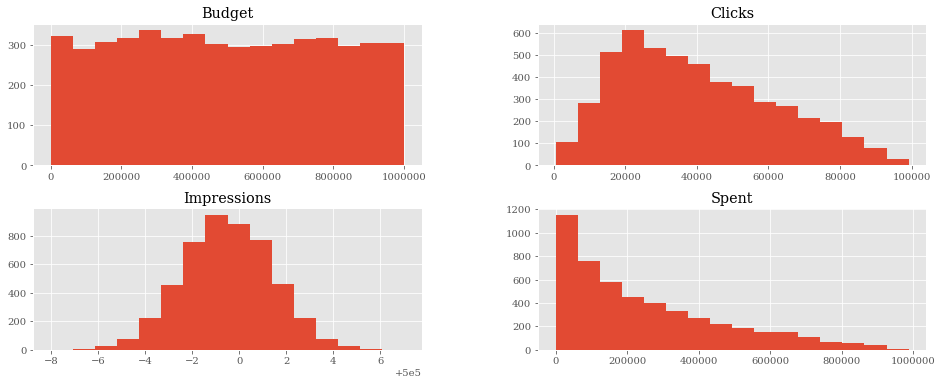

In [73]:
df[['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=16, figsize=(16, 6)); #note: ;를 추가하면 graph만 나오도록 함(line output은 제거함)

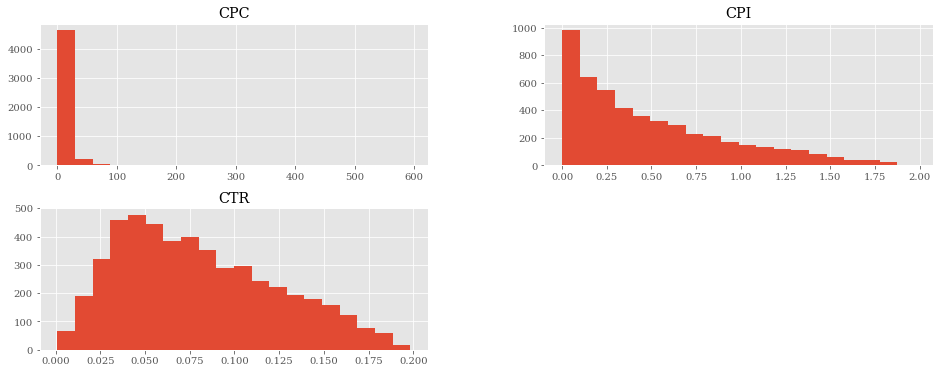

In [74]:
df[['CTR', 'CPC', 'CPI']].hist(
    bins=20, figsize=(16, 6));

0       False
1       False
2        True
3       False
4       False
5       False
6       False
7       False
8        True
9       False
10      False
11      False
12      False
13      False
14       True
15      False
16      False
17      False
18       True
19      False
20      False
21      False
22      False
23      False
24       True
25      False
26      False
27      False
28      False
29      False
        ...  
4917    False
4918    False
4919     True
4920    False
4921    False
4922     True
4923    False
4924    False
4925    False
4926    False
4927     True
4928    False
4929     True
4930    False
4931    False
4932    False
4933    False
4934    False
4935    False
4936     True
4937    False
4938    False
4939     True
4940    False
4941    False
4942    False
4943    False
4944     True
4945    False
4946     True
dtype: bool


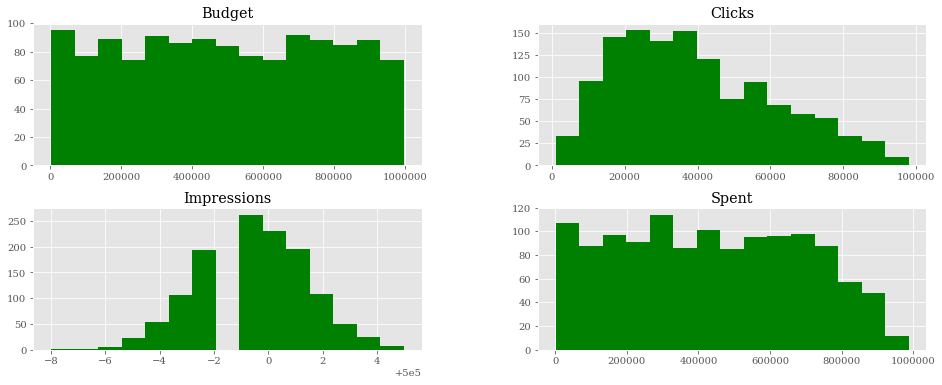

In [76]:
# let's see the campaigns whose spent is > than 75% of the budget
mask = (df.Spent > 0.75 * df.Budget)
df[mask][['Budget', 'Spent', 'Clicks', 'Impressions']].hist( #todo: df[mask] 이 부분은 정확하게 이해가 안됨
    bins=15, figsize=(16, 6), color='g');

             Duration     Budget    Clicks  Impressions      Spent        CTR  \
Day of Week                                                                     
Friday         269533  365316205  29560592    367499637  185709106  59.121241   
Monday         247508  346809804  27858790    347999613  170470300  55.717640   
Saturday       261535  350256468  28667894    346999630  184772057  57.335849   
Sunday         248458  345476948  27367657    350999583  172505044  54.735384   
Thursday       269375  353592391  29663290    364999638  172139678  59.326640   
Tuesday        247454  347902862  27124550    342999724  169122913  54.249144   
Wednesday      270421  351186874  28000125    351999673  173908504  56.000309   

                     CPC         CPI    Age  
Day of Week                                  
Friday       7137.903816  371.418538  39249  
Monday       6966.000820  340.941006  37483  
Saturday     6454.250595  369.544478  36488  
Sunday       7171.692661  345.010474  37

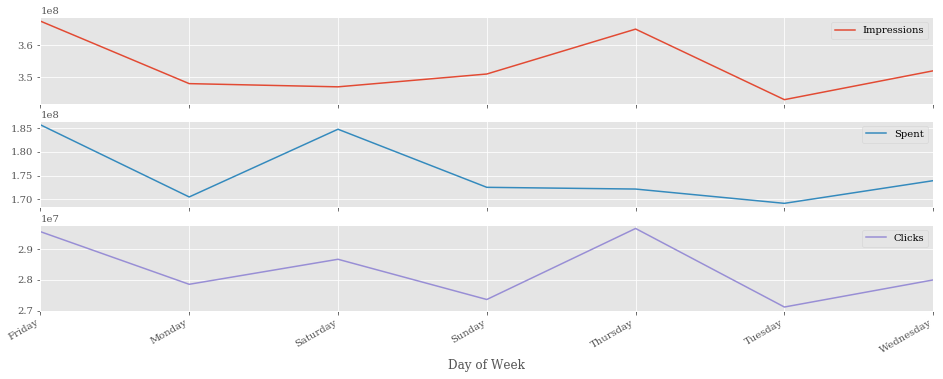

In [89]:
# Let's aggregate per Day of the Week
df_weekday = df.groupby(['Day of Week']).sum()
print(df_weekday)
df_weekday[['Impressions', 'Spent', 'Clicks']].plot(
    figsize=(16, 6), subplots=True);

In [90]:
# Let's aggregate per gender
agg_config = {
    'Impressions': {
        'Mean Impr': 'mean',
        'Std Impr': 'std',
    },
    'Spent': ['mean', 'std'],
}

df.groupby(['Target Gender', 'Target Age']).agg(agg_config)

Impressions             Spent               
                           Mean Impr  Std Impr    mean            std
Target Gender Target Age                                             
B             20-25           499999  2.137100  263085  224808.943975
              20-30           499999  1.944003  276992  225956.609112
              20-35           499999  1.858661  222256  208625.595452
              20-40           499999  1.968881  254441  243934.460481
              20-45           499998  1.791310  298535  250073.025829
              25-30           499999  1.933768  257833  224425.292922
              25-35           499999  1.670116  228971  246921.728626
              25-40           499999  1.999594  245469  213740.332439
              25-45           499999  2.243542  238113  242506.078570
              25-50           499999  2.032819  203049  164895.682487
              30-35           499999  2.146674  261535  215675.456864
              30-40           499999  2.124949  255167  216774.447676
              30-45           499999  1.890124  293714  260631.680561
              30-50           499999  2.183571  235524  198401.355112
              30-55           499999  2.185813  288193  165672.208956
              35-40           499999  2.024884  252655  229065.486853
              35-45           499999  2.025019  242351  215128.581712
              35-50           499999  2.173768  257526  225417.073194
              35-55           499999  2.375830  205134  208593.216157
              35-60           499999  1.206045  163450  215858.956436
              40-45           499998  1.915973  232892  239061.180457
              40-50           499999  2.061501  239729  219488.968390
              40-55           499999  2.137335  272537  228816.971130
              40-60           499999  1.866152  277546  217397.726928
              40-65           500000  1.538716  324162  176935.043531
              45-50           499999  2.008753  157878  159296.471065
              45-55           499999  2.097618  246126  226476.357373
              45-60           499999  2.533413  181492  202641.764451
              45-65           500000  1.817195  262894  247044.223363
F             20-25           499999  2.174665  299291  241816.243253
...                              ...       ...     ...            ...
M             20-25           499999  2.226204  224207  176390.911006
              20-30           499999  1.927511  288173  251596.686626
              20-35           499999  2.574100  236958  214797.963508
              20-40           499999  2.034473  261331  241141.220405
              20-45           500000  2.293086  346479  248425.134726
              25-30           499999  1.807436  243354  221133.542349
              25-35           499999  2.086386  262515  240625.737279
              25-40           499999  1.844497  239004  215645.511348
              25-45           499999  2.127718  249223  217873.961444
              25-50           499999  2.947154  235847  246332.785522
              30-35           499999  2.069805  243552  178992.070763
              30-40           499999  1.987814  272908  238401.788987
              30-45           499999  1.966016  268317  226356.489268
              30-50           499999  1.871103  287907  236680.989788
              30-55           500000  2.060975  165728  147979.395583
              35-40           499999  2.107089  201177  201292.419100
              35-45           499999  1.789562  277157  224572.143173
              35-50           499999  2.417415  232686  208837.650321
              35-55           499999  1.993779  267238  234719.364541
              35-60           499999  2.256046  245579  249987.072825
              40-45           499999  1.935153  260698  252319.830267
              40-50           499999  2.141139  276333  218092.418749
              40-55           499999  1.891657  224855  200326.403946
              40-60           49999

In [91]:
# finally, let's make a pivot table
pivot = df.pivot_table(
    values=['Impressions', 'Clicks', 'Spent'],
    index=['Target Age'],
    columns=['Target Gender'],
    aggfunc=np.sum
)
pivot

Impressions                             Clicks             \
Target Gender           B           F           M          B          F   
Target Age                                                                
20-25          36999954.0  31999966.0  35999985.0  2800887.0  2583128.0   
20-30          35999935.0  39499961.0  30499974.0  3450073.0  3136429.0   
20-35          42499948.0  35999926.0  29999972.0  3245509.0  2760694.0   
20-40          37999980.0  33999996.0  39999969.0  2756909.0  2778754.0   
20-45           6999984.0   6499995.0   7000011.0   630246.0   613495.0   
25-30          37499964.0  40499961.0  41499950.0  3074147.0  2938981.0   
25-35          33999978.0  45499961.0  39999947.0  2706163.0  3399516.0   
25-40          39499943.0  36499949.0  43999957.0  3177349.0  2924709.0   
25-45          31999989.0  40999974.0  41499992.0  2688274.0  2892988.0   
25-50           8499993.0   4999993.0   7499994.0   751202.0   471360.0   
30-35          33999983.0  34499949.0  43999939.0  2924372.0  2990560.0   
30-40          45999951.0  34499964.0  37999969.0  4016696.0  2670378.0   
30-45          40999943.0  40999969.0  33499977.0  3288480.0  3532561.0   
30-50          47999930.0  28499978.0  38499952.0  3944728.0  2257198.0   
30-55           4499995.0   8999989.0  10500001.0   437582.0   559077.0   
35-40          35999956.0  36999957.0  37999963.0  2653381.0  3032729.0   
35-45          36999940.0  42999950.0  39999940.0  2977187.0  3598624.0   
35-50          36499965.0  37999997.0  47499973.0  2911815.0  3242296.0   
35-55          38499999.0  32999980.0  45999932.0  2636268.0  2992227.0   
35-60           5499993.0   6999993.0   6499995.0   425836.0   712287.0   
40-45          29499933.0  35499980.0  44999938.0  2440956.0  2918768.0   
40-50          34499953.0  41499952.0  36499967.0  2954280.0  3351360.0   
40-55          34499959.0  29999950.0  32499953.0  2874715.0  2264078.0   
40-60          34499983.0  41499968.0  42999952.0  3002719.0  3369792.0   
40-65           8500006.0   9499997.0   7999988.0   714476.0   672202.0   
45-50           9499992.0   7499989.0   6999986.0   848654.0   425258.0   
45-55           7999984.0   6999986.0   6499997.0   604896.0   444466.0   
45-60           5499992.0   9499995.0   6999982.0   558472.0   858099.0   
45-65           7000001.0   6000006.0   5499989.0   670717.0   443491.0   
45-70                 NaN   1000001.0    499996.0        NaN   126039.0   

                               Spent                          
Target Gender          M           B           F           M  
Target Age                                                    
20-25          2425222.0  19468323.0  19154635.0  16142947.0  
20-30          2487485.0  19943495.0  18129437.0  17578554.0  
20-35          2339535.0  18891794.0  16387875.0  14217522.0  
20-40          3329218.0  19337591.0  19973982.0  20906521.0  
20-45           537189.0   4179490.0   4388696.0   4850712.0  
25-30          3213993.0  19337484.0  19713158.0  20198461.0  
25-35          3189007.0  15570089.0  25438187.0  21001203.0  
25-40          3505526.0  19392060.0  15525205.0  21032380.0  
25-45          3028710.0  15239244.0  21299602.0  20685557.0  
25-50           694774.0   3451835.0   1884082.0   3537707.0  
30-35          3355984.0  17784422.0  17171052.0  21432632.0  
30-40          2823128.0  23475391.0  16370664.0  20741027.0  
30-45          2686565.0  24084592.0  20223671.0  17977245.0  
30-50          3142897.0  22610328.0  14469163.0  22168900.0  
30-55           827642.0   2593742.0   3580440.0   3480302.0  
35-40          3028481.0  18191222.0  14575053.0  15289493.0  
35-45          3234669.0  17933998.0  20405773.0  22172569.0  
35-50          3516540.0  18799405.0  17941787.0  22105219.0  
35-55          3578580.0  15795321.0  16951905.0  24585945.0  
35-60           542152.0   1797952.0   2885945.0   3192535.0  
40-45          3334766.0  13740675.0  16298090.0  23462881.0  
40-50          2927301.0  